In [1]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_addons as tfa

In [2]:
tf.__version__

'2.8.0'

In [3]:
batch_size = 64
img_height = 180
img_width = 180

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "chest_xray\\train",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "rgb")

Found 5216 files belonging to 2 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "chest_xray\\val",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "rgb")

Found 16 files belonging to 2 classes.


In [6]:
test_ds = tf.keras.utils.image_dataset_from_directory(
  "chest_xray\\test",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  color_mode = "rgb")

Found 624 files belonging to 2 classes.


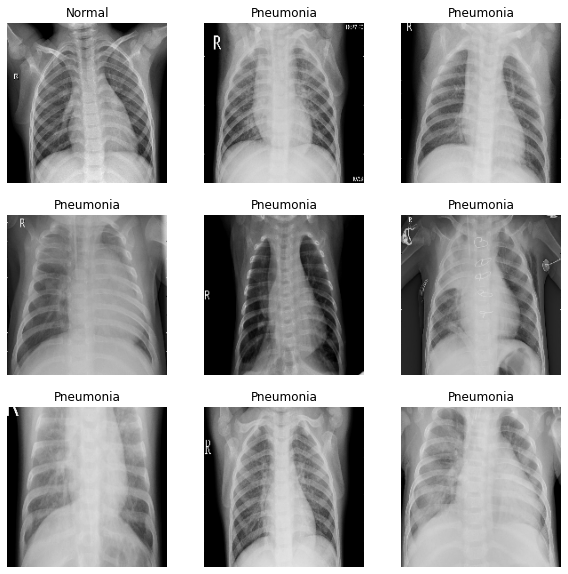

In [7]:
import matplotlib.pyplot as plt

class_names = ["Normal", "Pneumonia"]

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [8]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 180, 180, 3)
(64,)


In [9]:
model = tf.keras.applications.resnet.ResNet50(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=(180, 180, 3),
    pooling=None,
    classes=1000,
)




In [10]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = model(image_batch)
print(feature_batch.shape)

(64, 6, 6, 2048)


In [11]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [12]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [13]:
model.trainable = False

In [14]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 180, 180, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 186, 186, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 90, 90, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 90, 90, 64)   256         ['conv1_conv[0][0]']      

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 2048)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 1)


In [17]:
data_augmentation = tf.keras.Sequential([
  #tf.keras.layers.RandomFlip('horizontal'),
  #tf.keras.layers.RandomRotation(0.2),
  tf.keras.layers.Rescaling(1./127.5, offset=-1)
])


inputs = tf.keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
#x = preprocess_input(x)
x = model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                             

In [19]:
from tensorflow_addons.utils.types import AcceptableDTypes, FloatTensorLike
from typing import Optional
from tensorflow.keras import backend as K

class FBetaScore(tf.keras.metrics.Metric):
    def __init__(
        self,
        num_classes: FloatTensorLike,
        average: Optional[str] = None,
        beta: FloatTensorLike = 1.0,
        threshold: Optional[FloatTensorLike] = None,
        name: str = "fbeta_score",
        dtype: AcceptableDTypes = None,
        **kwargs,
    ):
        super().__init__(name=name, dtype=dtype)

        if average not in (None, "micro", "macro", "weighted"):
            raise ValueError(
                "Unknown average type. Acceptable values "
                "are: [None, 'micro', 'macro', 'weighted']"
            )

        if not isinstance(beta, float):
            raise TypeError("The value of beta should be a python float")

        if beta <= 0.0:
            raise ValueError("beta value should be greater than zero")

        if threshold is not None:
            if not isinstance(threshold, float):
                raise TypeError("The value of threshold should be a python float")
            if threshold > 1.0 or threshold <= 0.0:
                raise ValueError("threshold should be between 0 and 1")

        self.num_classes = num_classes
        self.average = average
        self.beta = beta
        self.threshold = threshold
        self.axis = None
        self.init_shape = []

        if self.average != "micro":
            self.axis = 0
            self.init_shape = [self.num_classes]

        def _zero_wt_init(name):
            return self.add_weight(
                name, shape=self.init_shape, initializer="zeros", dtype=self.dtype
            )

        self.true_positives = _zero_wt_init("true_positives")
        self.false_positives = _zero_wt_init("false_positives")
        self.false_negatives = _zero_wt_init("false_negatives")
        self.weights_intermediate = _zero_wt_init("weights_intermediate")

    def update_state(self, y_true, y_pred, sample_weight=None):
        if self.threshold is None:
            threshold = tf.reduce_max(y_pred, axis=-1, keepdims=True)
            # make sure [0, 0, 0] doesn't become [1, 1, 1]
            # Use abs(x) > eps, instead of x != 0 to check for zero
            y_pred = tf.logical_and(y_pred >= threshold, tf.abs(y_pred) > 1e-12)
        else:
            y_pred = y_pred > self.threshold

        y_true = tf.cast(y_true, self.dtype)
        y_pred = tf.cast(y_pred, self.dtype)

        def _weighted_sum(val, sample_weight):
            if sample_weight is not None:
                val = tf.math.multiply(val, tf.expand_dims(sample_weight, 1))
            return tf.reduce_sum(val, axis=self.axis)


        
        y_pred = tf.reshape(tf.cast(y_pred, self.dtype), [-1, self.num_classes])
        y_true = tf.reshape(tf.cast(y_true, self.dtype), [-1, self.num_classes])

        #print("y_pred shape: ",tf.shape(y_pred))
        #print("y_true shape: ",tf.shape(y_true))

        self.true_positives.assign_add(_weighted_sum(y_pred * y_true, sample_weight))
        self.false_positives.assign_add(
            _weighted_sum(y_pred * (1 - y_true), sample_weight)
        )
        self.false_negatives.assign_add(
            _weighted_sum((1 - y_pred) * y_true, sample_weight)
        )
        self.weights_intermediate.assign_add(_weighted_sum(y_true, sample_weight))

    def result(self):
        precision = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_positives
        )
        recall = tf.math.divide_no_nan(
            self.true_positives, self.true_positives + self.false_negatives
        )

        mul_value = precision * recall
        add_value = (tf.math.square(self.beta) * precision) + recall
        mean = tf.math.divide_no_nan(mul_value, add_value)
        f1_score = mean * (1 + tf.math.square(self.beta))

        if self.average == "weighted":
            weights = tf.math.divide_no_nan(
                self.weights_intermediate, tf.reduce_sum(self.weights_intermediate)
            )
            f1_score = tf.reduce_sum(f1_score * weights)

        elif self.average is not None:  # [micro, macro]
            f1_score = tf.reduce_mean(f1_score)

        return f1_score

    def get_config(self):
        """Returns the serializable config of the metric."""

        config = {
            "num_classes": self.num_classes,
            "average": self.average,
            "beta": self.beta,
            "threshold": self.threshold,
        }

        base_config = super().get_config()
        return {**base_config, **config}

    def reset_state(self):
        reset_value = tf.zeros(self.init_shape, dtype=self.dtype)
        K.batch_set_value([(v, reset_value) for v in self.variables])

    def reset_states(self):
        # Backwards compatibility alias of `reset_state`. New classes should
        # only implement `reset_state`.
        # Required in Tensorflow < 2.5.0
        return self.reset_state()

In [20]:
class F1Score_TEST(FBetaScore):
    def __init__(
        self,
        num_classes: tfa.utils.types.FloatTensorLike,
        average: str = None,
        threshold: Optional[tfa.utils.types.FloatTensorLike] = None,
        name: str = "f1_score",
        dtype: tfa.utils.types.AcceptableDTypes = None,
    ):
        super().__init__(num_classes, average, 1.0, threshold, name=name, dtype=dtype)

    def get_config(self):
        base_config = super().get_config()
        del base_config["beta"]
        return base_config

In [21]:
base_learning_rate = 0.001
f1_score = F1Score_TEST(num_classes = 2, average='weighted', threshold = 0.5)
#f_beta = tfa.metrics.FBetaScore(num_classes = 2, avarage='weighted', f_beta=1.0)

model.compile(optimizer=tfa.optimizers.RectifiedAdam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy', f1_score], jit_compile=True)

In [22]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 180, 180, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 2049      
                                                             

In [23]:
len(model.trainable_variables)

2

In [25]:
initial_epochs = 10
print(model.evaluate(val_ds))
loss0, accuracy0, f1_score0 = model.evaluate(val_ds)

1/1 [==============================] - 1s 801ms/step - loss: 0.6769 - accuracy: 0.5000 - f1_score: 0.0000e+00
[0.6768749952316284, 0.5, 0.0]
1/1 [==============================] - 1s 885ms/step - loss: 0.6769 - accuracy: 0.5000 - f1_score: 0.0000e+00


In [26]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))
print("initial f1_score: {:.2f}".format(f1_score0))

initial loss: 0.68
initial accuracy: 0.50
initial f1_score: 0.00


In [27]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds,
                    use_multiprocessing = True)

Epoch 1/10
82/82 [==============================] - 181s 2s/step - loss: 0.5680 - accuracy: 0.6875 - f1_score: 0.8000 - val_loss: 0.7914 - val_accuracy: 0.5000 - val_f1_score: 0.6853
Epoch 2/10
82/82 [==============================] - 171s 2s/step - loss: 0.5280 - accuracy: 0.7504 - f1_score: 0.8460 - val_loss: 0.8022 - val_accuracy: 0.5625 - val_f1_score: 0.6970
Epoch 3/10
82/82 [==============================] - 167s 2s/step - loss: 0.4896 - accuracy: 0.7722 - f1_score: 0.8557 - val_loss: 0.8000 - val_accuracy: 0.5625 - val_f1_score: 0.6970
Epoch 4/10
82/82 [==============================] - 170s 2s/step - loss: 0.4618 - accuracy: 0.7941 - f1_score: 0.8664 - val_loss: 0.8675 - val_accuracy: 0.5625 - val_f1_score: 0.6970
Epoch 5/10
82/82 [==============================] - 187s 2s/step - loss: 0.4362 - accuracy: 0.8052 - f1_score: 0.8726 - val_loss: 0.8199 - val_accuracy: 0.5625 - val_f1_score: 0.7254
Epoch 6/10
82/82 [==============================] - 202s 2s/step - loss: 0.4228 - acc

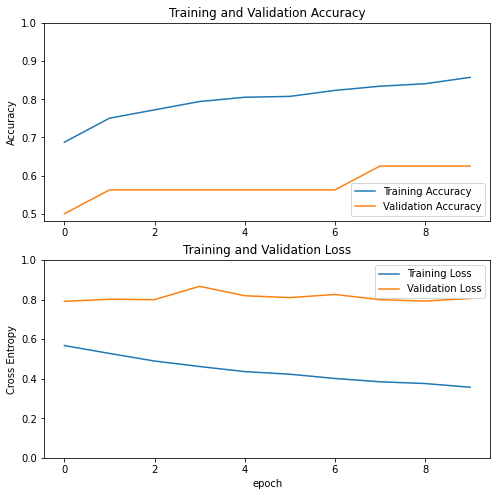

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [30]:
loss, accuracy, f1_score = model.evaluate(test_ds)
print('Test accuracy :', accuracy)
print('Test f1_score :', f1_score)

10/10 [==============================] - 24s 2s/step - loss: 0.5555 - accuracy: 0.7356 - f1_score: 0.8212
Test accuracy : 0.7355769276618958
Test f1_score : 0.821234941482544
